In [1]:
import pickle
import nltk
import json
import random

### Reading the cleaned tokens

In [7]:

with open("cleaned_text.txt", "rb") as fp:   # Unpickling
    cleaned_text = pickle.load(fp)
with open("cleaned_twitter.txt", "rb") as fp:   # Unpickling
    cleaned_twitter = pickle.load(fp)
cleaned_corpus=cleaned_text+cleaned_twitter
print(len(cleaned_corpus))

101098262


### Creating the sequences 

In [6]:

def create_data(length):
    seq=[]
    start=random.randint(0, len(cleaned_corpus)//2) # Used half of the corpus due to memory error
    for i in range(length,len(cleaned_corpus)//2):
        words = cleaned_corpus[i-length+start:i+start]
        line = ' '.join(words)
        seq.append(line)
        if i % 2000000==0:
            print(i , 'tokens done')
    with open('len'+str(length)+'.json', 'w') as fp:
        json.dump(seq, fp)
    
    del seq
    

In [11]:
#Sequence of length 2
create_data(2)

2000000 tokens done
4000000 tokens done
6000000 tokens done
8000000 tokens done
10000000 tokens done
12000000 tokens done
14000000 tokens done
16000000 tokens done
18000000 tokens done
20000000 tokens done
22000000 tokens done
24000000 tokens done
26000000 tokens done
28000000 tokens done
30000000 tokens done
32000000 tokens done
34000000 tokens done
36000000 tokens done
38000000 tokens done
40000000 tokens done
42000000 tokens done
44000000 tokens done
46000000 tokens done
48000000 tokens done
50000000 tokens done


In [5]:
#Sequence of length 4
create_data(4)

2000000 tokens done
4000000 tokens done
6000000 tokens done
8000000 tokens done
10000000 tokens done
12000000 tokens done
14000000 tokens done
16000000 tokens done
18000000 tokens done
20000000 tokens done
22000000 tokens done
24000000 tokens done
26000000 tokens done
28000000 tokens done
30000000 tokens done
32000000 tokens done
34000000 tokens done
36000000 tokens done
38000000 tokens done
40000000 tokens done
42000000 tokens done
44000000 tokens done
46000000 tokens done
48000000 tokens done
50000000 tokens done


In [6]:
#Sequence of length 7
create_data(7)

2000000 tokens done
4000000 tokens done
6000000 tokens done
8000000 tokens done
10000000 tokens done
12000000 tokens done
14000000 tokens done
16000000 tokens done
18000000 tokens done
20000000 tokens done
22000000 tokens done
24000000 tokens done
26000000 tokens done
28000000 tokens done
30000000 tokens done
32000000 tokens done
34000000 tokens done
36000000 tokens done
38000000 tokens done
40000000 tokens done
42000000 tokens done
44000000 tokens done
46000000 tokens done
48000000 tokens done
50000000 tokens done


### Encoding Data and splitting it into x and y

In [2]:
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
import pickle
import numpy as np
def encoding_data(length):
    with open('len'+str(length)+'.json', 'r') as fp:
        seq=json.load( fp)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(seq[:200000])
    
    sequences = tokenizer.texts_to_sequences(seq[:200000])
    
    sequences=np.array(sequences)
    vocab=len(tokenizer.word_counts)+1
    data_x=sequences[:,:-1]
    data_y=sequences[:,-1]
    data_y = to_categorical(data_y, num_classes=vocab)
    words_to_index = tokenizer.word_index
    with open('tokenizer1_len'+str(length)+'.pickle', 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    del seq
    return data_x,data_y,vocab,words_to_index

Using TensorFlow backend.


In [3]:
'''
#x,y,v=encoding_data(2)
import numpy as np 
embeddings_index=np.load('embeddings_index.npy',allow_pickle=True)
embeddings_index=dict(enumerate(embeddings_index.flatten(), 1))
'''

In [13]:
'''
embeddings_index = dict()
f = open('glove.42B.300d.txt',encoding='UTF-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

import numpy as np
np.save('embeddings_index.npy',embeddings_index)
'''

In [4]:
'''
def embedding(vocab_size,wti):
    embedding_matrix = np.zeros((vocab_size, 300))
    for word, i in wti.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix
'''

### Preparing the LSTM models

In [3]:
def lstm_model(length,unit1,unit2,n):
    import matplotlib.pyplot as plt
    from tensorflow.keras.regularizers import l2
    from tensorflow.keras.layers import LSTM, Activation, Dropout, Dense, Input,Embedding,Bidirectional
    from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,LearningRateScheduler
    from tensorflow.keras.models import Model,Sequential
    from tensorflow.keras.optimizers import Adam
    # Calling the encoding function to get the data of specified length and the vocabulary
    data_x,data_y,v,wti=encoding_data(length) 
    print("Data Encoded")
    print("Data_x",data_x[:5])
    print("Data_y",data_y[:5])
    print("Vocab_Size",v)
   
    # Preparing the model based on the inputs of unit1 ,unit2 and vocab values 
    model = Sequential()
    #model.add(Embedding(input_dim=v, output_dim=300 , input_length=length-1, weights = [embed_matrix], trainable=False))
    model.add(Embedding(v, length-1, input_length=length-1))
    model.add(Bidirectional(LSTM(unit1, return_sequences=True)))
    model.add(LSTM(unit2))
    model.add(Dropout(0.5))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(v, activation='softmax'))
    print(model.summary())
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])
    filepath="lstm_len"+str(length)+".hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
    
    def scheduler(epoch):
        
        if epoch < 60:
            return 0.001
        elif epoch < 100:
            return 0.0005
        else:
            return 0.0001
    lr = LearningRateScheduler(scheduler)
    callbacks_list = [checkpoint,lr]
    # fit model with epochs 130 
    
    history=model.fit(data_x, data_y,batch_size=128, epochs=n,callbacks=callbacks_list)
    del data_x,data_y,v,wti
    
    # Plotting the loss and accuracy achieved by the model in each epoch
    fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(20,10))
    ax[0].plot(history.history['loss'])
    ax[1].plot(history.history['accuracy'])
    ax[0].set_title('model loss')
    ax[1].set_title('model Accuracy')
    ax[0].set_ylabel('loss')
    ax[0].set_xlabel('epoch')
    ax[1].set_ylabel('accuracy')
    ax[1].set_xlabel('epoch')
    fig.tight_layout(pad=10.0)
    plt.show()

Data Encoded
Data_x [[  1]
 [683]
 [ 31]
 [ 21]
 [ 10]]
Data_y [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]
Vocab_Size 24329
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1, 1)              24329     
_________________________________________________________________
bidirectional (Bidirectional (None, 1, 400)            323200    
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                90200     
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 50)                2550      
________________________________________________

Epoch 00036: loss improved from 6.61148 to 6.60932, saving model to lstm_len2.hdf5
Epoch 37/60
1563/1563 [==============================] - 362s 232ms/step - loss: 6.5851 - accuracy: 0.0862 - los

Epoch 00037: loss improved from 6.60932 to 6.60324, saving model to lstm_len2.hdf5
Epoch 38/60
1563/1563 [==============================] - 332s 213ms/step - loss: 6.5815 - accuracy: 0.0867

Epoch 00038: loss improved from 6.60324 to 6.59640, saving model to lstm_len2.hdf5
Epoch 39/60
1563/1563 [==============================] - 336s 215ms/step - loss: 6.5816 - accuracy: 0.0870

Epoch 00039: loss improved from 6.59640 to 6.59112, saving model to lstm_len2.hdf5
Epoch 40/60
1563/1563 [==============================] - 304s 195ms/step - loss: 6.5727 - accuracy: 0.0889

Epoch 00040: loss improved from 6.59112 to 6.58699, saving model to lstm_len2.hdf5
Epoch 41/60
1563/1563 [==============================] - 316s 202ms/step - loss: 6.5616 - accuracy: 0.0903

Epoch 00041: loss improved from 6.58699

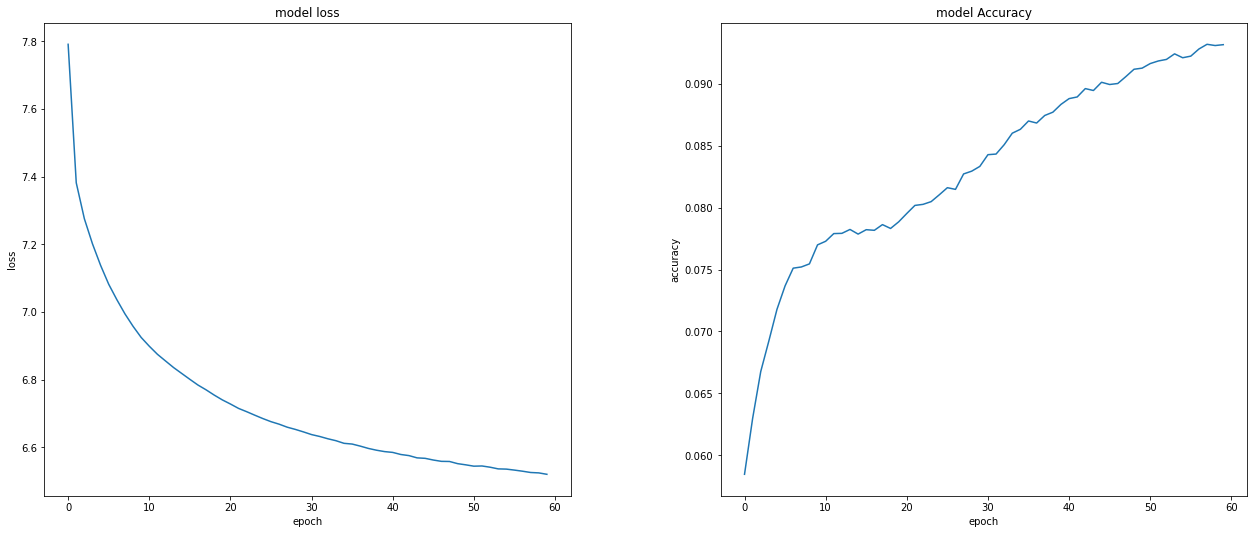

In [4]:
#Here the history is of length 1 ,Bidirectional LSTM layer has 300 units and LSTM layer has 100 units
lstm_model(2,200,50,60)

Data Encoded
Data_x [[  517  1227 24245]
 [ 1227 24245    12]
 [24245    12     6]
 [   12     6     4]
 [    6     4   518]]
Data_y [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Vocab_Size 24246
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 3, 3)              72738     
_________________________________________________________________
bidirectional (Bidirectional (None, 3, 400)            326400    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               200400    
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 50)     

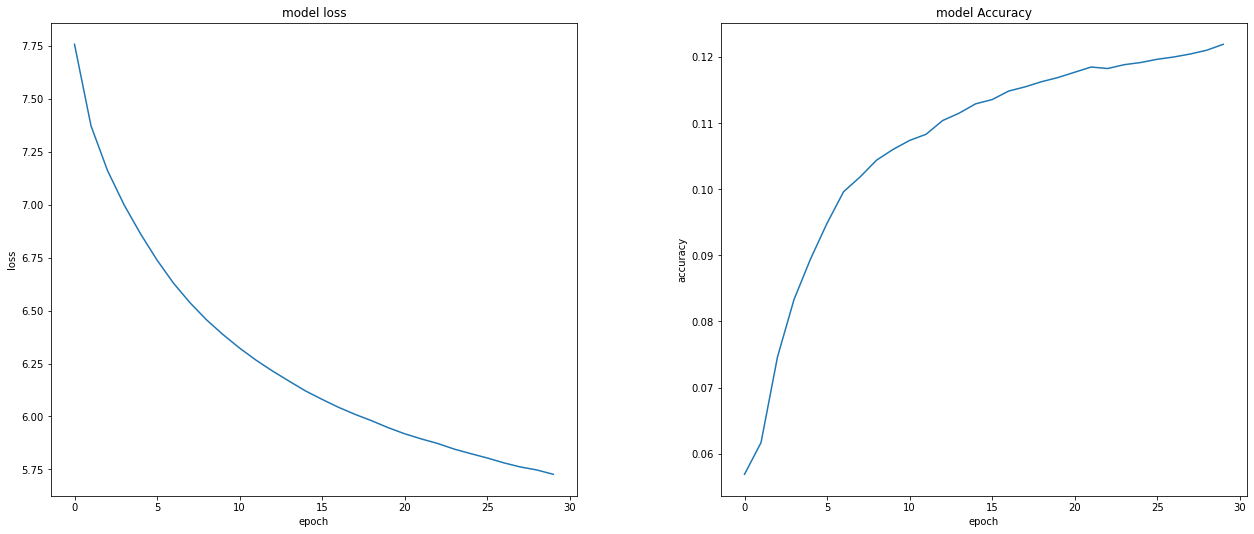

In [4]:
#Here the history is of length 3 ,Bidirectional LSTM layer has 250 units and LSTM layer has 100 units
lstm_model(4,200,100,30)

Data Encoded
Data_x [[    8    93 24301  2751    52     4]
 [   93 24301  2751    52     4   114]
 [24301  2751    52     4   114     2]
 [ 2751    52     4   114     2  1325]
 [   52     4   114     2  1325     8]]
Data_y [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Vocab_Size 24302
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 6, 6)              145812    
_________________________________________________________________
bidirectional (Bidirectional (None, 6, 128)            36352     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                20608     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
____________________

Epoch 36/50
1563/1563 [==============================] - 389s 249ms/step - loss: 5.9227 - accuracy: 0.1160

Epoch 00036: loss improved from 5.96248 to 5.94659, saving model to lstm_len7.hdf5
Epoch 37/50
1563/1563 [==============================] - 452s 289ms/step - loss: 5.9014 - accuracy: 0.1177

Epoch 00037: loss improved from 5.94659 to 5.93237, saving model to lstm_len7.hdf5
Epoch 38/50
1563/1563 [==============================] - 476s 304ms/step - loss: 5.8865 - accuracy: 0.1169

Epoch 00038: loss improved from 5.93237 to 5.91637, saving model to lstm_len7.hdf5
Epoch 39/50
1563/1563 [==============================] - 439s 281ms/step - loss: 5.8703 - accuracy: 0.1179

Epoch 00039: loss improved from 5.91637 to 5.90760, saving model to lstm_len7.hdf5
Epoch 40/50
1563/1563 [==============================] - 461s 295ms/step - loss: 5.8723 - accuracy: 0.1173

Epoch 00040: loss improved from 5.90760 to 5.89755, saving model to lstm_len7.hdf5
Epoch 41/50
1563/1563 [======================

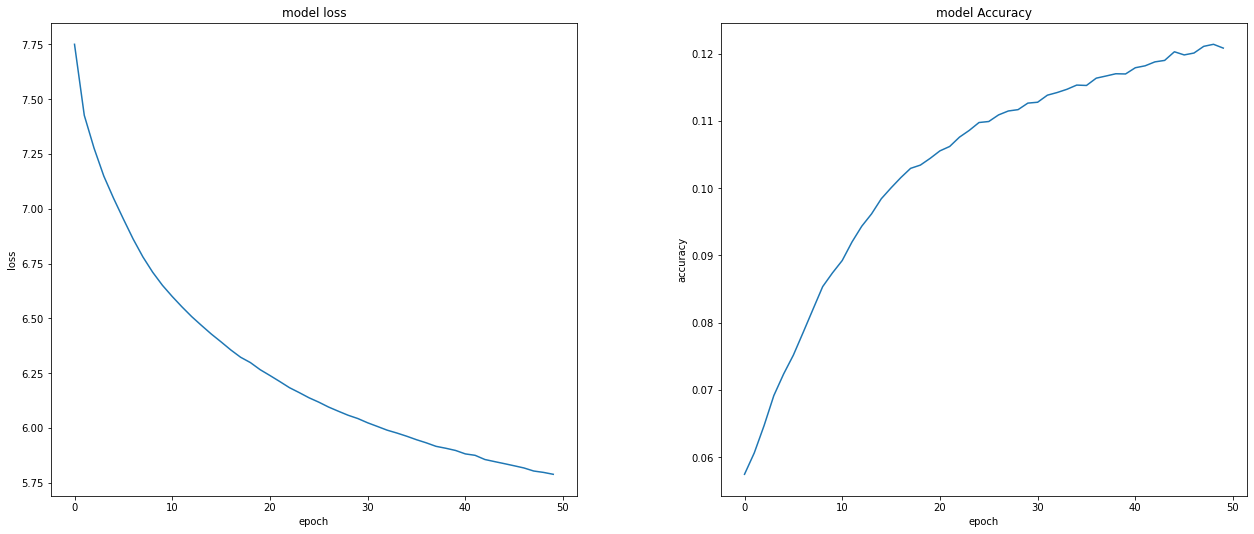

In [4]:
#Here the history is of length 6 ,Bidirectional LSTM layer has 150 units and LSTM layer has 50 units
lstm_model(7,64,32,50)

### Creating test data to test the models

In [5]:
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
import pickle
import numpy as np

from tensorflow.keras.preprocessing.sequence import pad_sequences
'''
start - random integer that indicates the starting index of tokens in the test data
temp_length - length of each line in the test corpus from which test data will be created
length - length of history + next word in the test data
'''
def create_testdata2(start,temp_length,length):
    seq=[]
    
    for i in range(temp_length,50000):
        words = cleaned_corpus[i-temp_length+start:i+start]
        line = ' '.join(words)
        seq.append(line)
        if i % 10000==0:
            print(i , 'tokens done')
    with open('tokenizer1_len'+str(length)+'.pickle', 'rb') as handle:
        tokenizer = pickle.load(handle)
    
    
    sequences = tokenizer.texts_to_sequences(seq)
    sequences = pad_sequences(sequences, maxlen=length, truncating='pre')
    sequences=np.array(sequences)
    
    vocab=len(tokenizer.word_counts)+1
    print(vocab)
    data_x=sequences[:,:-1]
    data_y=sequences[:,-1]
    data_y = to_categorical(data_y, num_classes=vocab)
    del seq,sequences
    return data_x,data_y
    

In [6]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
file="lstm_len7.hdf5"
model_len7 = load_model(file)
model_len7.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])
    
file="lstm_len4.hdf5"
model_len4 = load_model(file)
model_len4.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

file="lstm_len2.hdf5"
model_len2 = load_model(file)
model_len2.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

In [9]:
# Setting the start and temp_length
start=random.randint(1, 1000)
temp_length=random.randint(1, 10)


In [11]:
len2_x,len2_y=create_testdata2(start,temp_length,2)
model_len2.evaluate(x=len2_x,y=len2_y)
del len2_x,len2_y

10000 tokens done
20000 tokens done
30000 tokens done
40000 tokens done
24329
1563/1563 [==============================] - 65s 32ms/step - loss: 7.7570 - accuracy: 0.0849


With only 1 word as history, loss achieved is 9.29

In [9]:
len4_x,len4_y=create_testdata2(start,temp_length,4)
model_len4.evaluate(x=len4_x,y=len4_y)
del len4_x,len4_y

10000 tokens done
20000 tokens done
30000 tokens done
40000 tokens done
24246
1563/1563 [==============================] - 69s 38ms/step - loss: 9.3322 - accuracy: 0.1030


With  3 words as history, loss achieved is 27.39

In [10]:
len7_x,len7_y=create_testdata2(start,temp_length,7)
model_len7.evaluate(x=len7_x,y=len7_y)
del len7_x,len7_y

10000 tokens done
20000 tokens done
30000 tokens done
40000 tokens done
24302
1563/1563 [==============================] - 101s 58ms/step - loss: 12.1475 - accuracy: 0.0242


With 6 words as history, loss achieved is 22.77

#### Although the loss for trigram and 6 gram history is quite large , I will use them for predictions as they take into account the context which generally provides a better result than just the previous word.

In [5]:
import re 
from nltk.tokenize import word_tokenize
def extra_space(text):
    new_text= re.sub("\s+"," ",text)
    return new_text
def sp_charac(text):
    new_text=re.sub("[^0-9A-Za-z ]", "" , text)
    return new_text
def tokenize_text(text):
    new_text=word_tokenize(text)
    return new_text

### Predicting Next Word

In [6]:

def predict_next():
    import tensorflow as tf
    tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
    from tensorflow.keras.preprocessing.sequence import pad_sequences
    from tensorflow.keras.models import load_model
    from tensorflow.keras.optimizers import Adam
    import pickle
    import time
  
    with open('tokenizer_len7.pickle', 'rb') as handle:
        tokenizer_len7 = pickle.load(handle)

    with open('tokenizer_len4.pickle', 'rb') as handle:
        tokenizer_len4 = pickle.load(handle)
    with open('tokenizer_len2.pickle', 'rb') as handle:
        tokenizer_len2 = pickle.load(handle)
    
    file="lstm_len7.hdf5"
    model_len7 = load_model(file)
    model_len7.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])
    
    file="lstm_len4.hdf5"
    model_len4 = load_model(file)
    model_len4.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

    file="lstm_len2.hdf5"
    model_len2 = load_model(file)
    model_len2.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])
    while(True):
        text=input()
        start= time.time()
        cleaned_text=extra_space(text)
        cleaned_text=sp_charac(cleaned_text)
        tokenized=tokenize_text(cleaned_text)
    
        line = ' '.join(tokenized)
        
    
        if len(tokenized)==1:
        
            encoded_text = tokenizer_len2.texts_to_sequences([line])
            pad_encoded = pad_sequences(encoded_text, maxlen=1, truncating='pre')
    
            for i in (model_len2.predict(pad_encoded)[0]).argsort()[-3:][::-1]:
    
    
                pred_word = tokenizer_len2.index_word[i]
                print("Next word suggestion:",pred_word)
        elif len(tokenized)<4:
            encoded_text = tokenizer_len4.texts_to_sequences([line])
            pad_encoded = pad_sequences(encoded_text, maxlen=3, truncating='pre')
    
            for i in (model_len4.predict(pad_encoded)[0]).argsort()[-3:][::-1]:
    
    
                pred_word = tokenizer_len4.index_word[i]
                print("Next word suggestion:",pred_word)
        else:
            encoded_text = tokenizer_len7.texts_to_sequences([line])
            pad_encoded = pad_sequences(encoded_text, maxlen=6, truncating='pre')
    
            for i in (model_len7.predict(pad_encoded)[0]).argsort()[-3:][::-1]:
    
    
                pred_word = tokenizer_len7.index_word[i]
                print("Next word suggestion:",pred_word)
        print('Time taken: ',time.time()-start)
   

In [7]:
predict_next()

I am 
Next word suggestion: precisely
Next word suggestion: controlling
Next word suggestion: learned
Time taken:  1.8980300426483154
ok fine lets go
Next word suggestion: to
Next word suggestion: on
Next word suggestion: for
Time taken:  1.6629693508148193
anything 
Next word suggestion: with
Next word suggestion: in
Next word suggestion: that
Time taken:  1.5450398921966553
everywhere I get this kind of 
Next word suggestion: tweaking
Next word suggestion: fulfilling
Next word suggestion: drained
Time taken:  0.06495428085327148
very well we will have
Next word suggestion: a
Next word suggestion: to
Next word suggestion: done
Time taken:  0.06795668601989746
why not when you are having
Next word suggestion: trouble
Next word suggestion: a
Next word suggestion: much
Time taken:  0.06793856620788574
New yoek
Next word suggestion: mexico
Next word suggestion: jersey
Next word suggestion: years
Time taken:  0.07395410537719727
instagrammear
Next word suggestion: a
Next word suggestion: t

KeyboardInterrupt: Interrupted by user